## Back Test Results Binary Classification

In [1]:
import pandas as pd
from pycaret.datasets import get_data
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(3000, 10)

In [3]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Current_Market_Stoploss,Rec1,Rec1_P,Rec2,Rec2_P,Rec3,Rec3_P
0,2554.0,42.0,Bullish,0.0,11.0,BUY,11.0,BUY,36.0,SELL
1,7173.0,34.0,Bearish,0.0,40.0,SELL,68.0,BUY,71.0,SELL
2,8267.0,3.0,Bearish,0.0,10.0,SELL,4.0,SELL,88.0,BUY
3,3263.0,18.0,Bearish,0.0,6.0,BUY,4.0,SELL,49.0,BUY
4,7244.0,61.0,Bearish,0.0,90.0,BUY,98.0,SELL,14.0,BUY


## Drop Predictions with Less than 20% LR Fit

In [4]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [5]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Current_Market_Stoploss,Rec1,Rec1_P,Rec2,Rec2_P,Rec3,Rec3_P
0,2554.0,42.0,Bullish,0.0,11.0,BUY,11.0,BUY,36.0,SELL
1,7173.0,34.0,Bearish,0.0,40.0,SELL,68.0,BUY,71.0,SELL
2,7244.0,61.0,Bearish,0.0,90.0,BUY,98.0,SELL,14.0,BUY
3,2119.0,79.0,Bearish,0.0,94.0,BUY,4.0,BUY,9.0,SELL
4,7020.0,82.0,Bullish,0.0,51.0,SELL,12.0,SELL,96.0,BUY


In [6]:
dataset.shape

(2268, 10)

## One-Hot Encoding

In [7]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_P'] = dataset['Rec1_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_P'] = dataset['Rec2_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_P'] = dataset['Rec3_P'].replace(['BUY','SELL'],[1,-1])

In [8]:
dataset['Rec1'] = dataset['Rec1'] * dataset['Rec1_P']
dataset['Rec2'] = dataset['Rec2'] * dataset['Rec2_P']
dataset['Rec3'] = dataset['Rec3'] * dataset['Rec3_P']

In [9]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Current_Market_Stoploss',
    'Rec1_P',
    'Rec2_P',
    'Rec3_P'
], axis=1)

In [10]:
dataset.head()

,Current_Market,Rec1,Rec2,Rec3
0,1,11.0,11.0,-36.0
1,0,-40.0,68.0,-71.0
2,0,90.0,-98.0,14.0
3,0,94.0,4.0,-9.0
4,1,-51.0,-12.0,96.0


In [11]:
data = dataset.sample(frac=0.75, random_state=800).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1701, 4)
Unseen Data For Predictions: (567, 4)


# Create Unseen DataFrame

In [12]:
data_unseen.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,-2.0,-93.0,-29.0
1,0,38.0,-91.0,-67.0
2,0,61.0,-83.0,38.0
3,1,2.0,17.0,-40.0
4,1,85.0,-89.0,-5.0


In [13]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1701, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5840,0.6454,0.5919,0.6039,0.5953,0.1673,0.1689,0.0490
lightgbm,Light Gradient Boosting Machine,0.5790,0.6137,0.6097,0.5933,0.5993,0.1556,0.1572,0.0120
gbc,Gradient Boosting Classifier,0.5765,0.5940,0.6129,0.5893,0.6000,0.1501,0.1507,0.0160
et,Extra Trees Classifier,0.5739,0.6476,0.5871,0.5916,0.5873,0.1468,0.1473,0.0410
dt,Decision Tree Classifier,0.5689,0.5683,0.5839,0.5888,0.5851,0.1363,0.1370,0.0060
ada,Ada Boost Classifier,0.5462,0.5604,0.6081,0.5599,0.5822,0.0873,0.0877,0.0150
knn,K Neighbors Classifier,0.5429,0.5500,0.5613,0.5613,0.5598,0.0841,0.0847,0.1210
nb,Naive Bayes,0.5370,0.5446,0.6581,0.5455,0.5962,0.0640,0.0661,0.1220
lr,Logistic Regression,0.5286,0.5377,0.6710,0.5374,0.5964,0.0453,0.0476,0.2100
ridge,Ridge Classifier,0.5286,0.0000,0.6710,0.5374,0.5964,0.0453,0.0476,0.0040


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

stop

In [15]:
MODEL = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6471,0.6252,0.6935,0.6515,0.6719,0.2909,0.2915
1,0.5630,0.5405,0.5968,0.5781,0.5873,0.1233,0.1233
2,0.5294,0.5490,0.5968,0.5441,0.5692,0.0531,0.0534
3,0.5546,0.6101,0.5484,0.5763,0.5620,0.1096,0.1097
4,0.5714,0.5640,0.6613,0.5775,0.6165,0.1358,0.1374
5,0.5294,0.5511,0.5161,0.5517,0.5333,0.0598,0.0600
6,0.5462,0.5665,0.5161,0.5714,0.5424,0.0947,0.0952
7,0.5798,0.6338,0.6452,0.5882,0.6154,0.1546,0.1554
8,0.6723,0.6964,0.7258,0.6716,0.6977,0.3410,0.3423
9,0.5714,0.6038,0.6290,0.5821,0.6047,0.1383,0.1388


In [16]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6387,0.6811,0.7258,0.6338,0.6767,0.2714,0.2746
1,0.5126,0.5518,0.5323,0.5323,0.5323,0.0235,0.0235
2,0.5798,0.6106,0.6290,0.5909,0.6094,0.1558,0.1561
3,0.6555,0.6367,0.5968,0.6981,0.6435,0.3141,0.3177
4,0.6387,0.7136,0.6935,0.6418,0.6667,0.2735,0.2744
5,0.5714,0.5690,0.5161,0.6038,0.5565,0.1468,0.1485
6,0.6134,0.6203,0.5806,0.6429,0.6102,0.2288,0.2300
7,0.6134,0.6602,0.6290,0.6290,0.6290,0.2255,0.2255
8,0.6387,0.6873,0.6613,0.6508,0.6560,0.2755,0.2756
9,0.6471,0.6967,0.7581,0.6351,0.6912,0.2868,0.2930


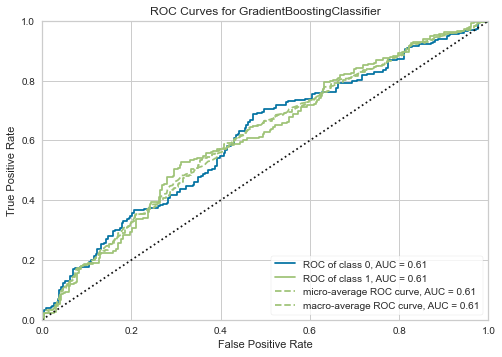

In [17]:
plot_model(TUNED_MODEL, plot = 'auc')

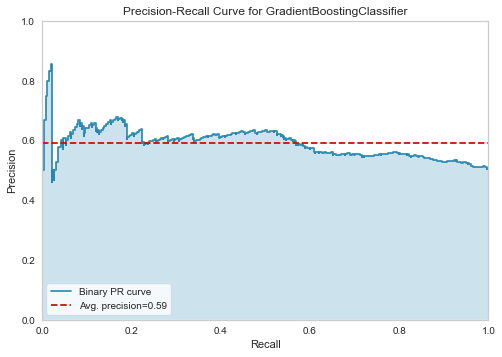

In [18]:
plot_model(TUNED_MODEL, plot = 'pr')

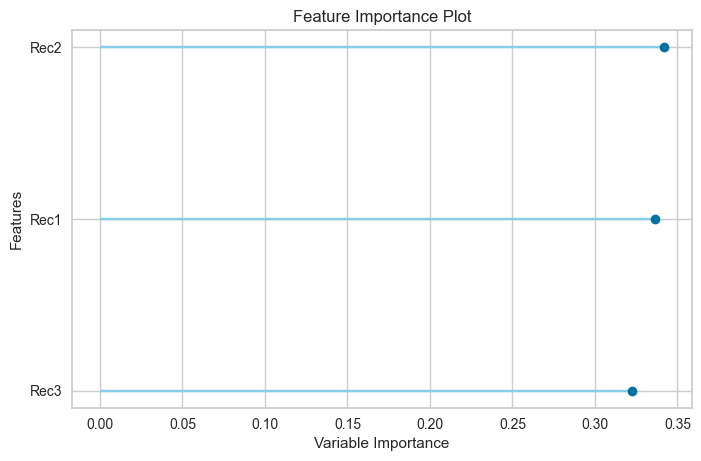

In [19]:
plot_model(TUNED_MODEL, plot='feature')

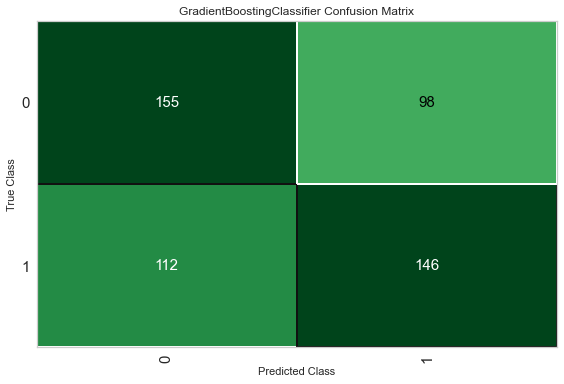

In [20]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [21]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5890,0.6081,0.5659,0.5984,0.5817,0.1784,0.1787


In [22]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [23]:
print(FINAL_MODEL)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=5,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0005,
                           min_impurity_split=None, min_samples_leaf=3,
                           min_samples_split=7, min_weight_fraction_leaf=0.0,
                           n_estimators=160, n_iter_no_change=None,
                           presort='deprecated', random_state=123,
                           subsample=0.45, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)


In [24]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9902,0.9996,0.9845,0.9961,0.9903,0.9804,0.9805


In [25]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1,Rec2,Rec3,Label,Score
0,0,-2.0,-93.0,-29.0,0,0.9773
1,0,38.0,-91.0,-67.0,0,0.7700
2,0,61.0,-83.0,38.0,0,0.8768
3,1,2.0,17.0,-40.0,1,0.6650
4,1,85.0,-89.0,-5.0,1,0.9560


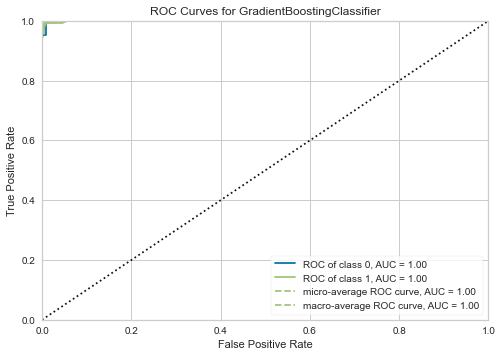

In [26]:
plot_model(FINAL_MODEL, plot = 'auc')

In [27]:
save_model(FINAL_MODEL,'FINAL_GBC_22Nov2021_EURUSD')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                             learning_rate=0.3, loss='deviance',
                                             max_depth=5, max_features=1.0,
                                             max_leaf_nodes=None,
            

In [28]:
SAVED_FINAL_MODEL = load_model('FINAL_GBC_22Nov2021_EURUSD')

Transformation Pipeline and Model Successfully Loaded


In [29]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [30]:
new_prediction.head(20)

,Current_Market,Rec1,Rec2,Rec3,Label,Score
0,0,-2.0,-93.0,-29.0,0,0.9773
1,0,38.0,-91.0,-67.0,0,0.7700
2,0,61.0,-83.0,38.0,0,0.8768
3,1,2.0,17.0,-40.0,1,0.6650
4,1,85.0,-89.0,-5.0,1,0.9560
5,1,-85.0,89.0,39.0,1,0.9444
6,0,-1.0,95.0,-66.0,0,0.8858
7,1,-22.0,-42.0,0.0,1,0.7234
8,1,23.0,42.0,-70.0,1,0.7317
9,0,37.0,50.0,-43.0,1,0.5853
